# 4. (Programming) Get two images, taken from the same scene but with scale transformations. Detect the scale invariant points on the two images. You can use the center of the circle to indicate the spatial position of the point and use the radius of the circle to indicate the characteristic scale of the point, just like the following example.

In [21]:
import cv2 as cv
import numpy as np

img=cv.imread("butterfly.png")
img=cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#convert image to float32
img = img.astype('float32')
#set the basic parameters
sigma,numIntervals,assumedBlur=1.6,3,0.5

The above code just reads in the image and set the basic parameters.

***

## First Step: Build Gaussian Pyramid

### 1-1: Generate Base Image

> We double the size of the input image using linear interpolation prior to building the first level of
the pyramid. 

As mentioned in the paper, we will preprocess the image and generate the base image. If the initial image is assumed to have been blured by a assumedBlur of $ \sigma_{0} $, we need to further blur it by $ \sigma^2-\sigma_{0}^2 $.

In [22]:
#Generate Base Image
image = cv.resize(img, (0, 0), fx=2, fy=2)
sigmaDiff = np.sqrt(max((sigma ** 2) - ((2 * assumedBlur) ** 2), 0.01))
# the image blur is now sigma instead of assumed_blur
#print(sigmaDiff)
baseImage=cv.GaussianBlur(image, (0, 0), sigmaX=sigmaDiff)

### 1-2: Calculate Number of Octaves

Number of octaves can be calculated with the formula: $$ {\lceil} {\log min(m,n)}/{\log 2}-1 {\rceil} $$

where m and n are the height and width of the image.

In [23]:
#Calculate number of octaves
numOctave=int(round(np.log(min(baseImage.shape)) / np.log(2) - 1))
print("Numbe of octaves: "+str(numOctave))

Numbe of octaves: 8


### 1-3: Generate Gaussian Kernels

> We choose to divide each octave of scale space (i.e., doubling of $ \sigma $) into an integer number, s, of intervals, so $ k = 2^{1/s} $. We must produce s + 3 images in the stack of blurred images for each octave, so that final extrema detection covers a complete octave.

We set the number of intervals as three, which means that each octave will have three layers where we can find extremums. An extremum needs to be larger than its 26 neighboring points, so we can't find any extremum at the toppest and lowest layers, so we must add two more layers so that we will have threee layers where we can find extremums. In that way, we have 5 layers in each difference of gaussian(dog) octaves, so we need 6 layers in each gaussian pyramid octave.

In [24]:
#Generate gaussian kernel
N=numIntervals+3 #number of images per octave
k = 2 ** (1.0 / numIntervals)
gaussianKernels = np.zeros(N)
gaussianKernels[0] = sigma
for i in range(1, N):
    sigmaPre = (k ** (i - 1)) * sigma
    sigmaTotal = k * sigmaPre
    gaussianKernels[i] = np.sqrt(sigmaTotal ** 2 - sigmaPre ** 2)
print("Gaussian kernels shown below:")
print(gaussianKernels)

Gaussian kernels shown below:
[1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]


As we see, we generate a gaussian kernel in the code above. But what does it mean? Well, the first value is just $ \sigma $ and we never use it. For the first octave, the first image has already been blurred by 1.6. And the remaining 5 images will 'go through' the gaussian kernel, which means that the second image will be further blurred by 1.2262735, the second image will be further blurred by 1.2262735 and 1.54500779 and etc. And we shall note here that $ \sqrt{1.6^2+1.2262735^2+1.54500779^2+1.94658784^2}=3.2 $, which means that the forth image is equivalently blurred by 3.2. The base image in the second octave is also blurred by this value. Why do we do this and how do we form a gaussian pyramid? We will expand on them later.

### 1-4: Generate Gaussian Images

We generate gaussian images and save the generated images inside the folder 'Gaussian_Pyramid'. As we can see in the code, we blur the image with gaussian kernels obtained in the last step and reduce the size of the third to last image by half to generate the base image of the next octave. As we have mentioned above, the third to last image is blurred with 3.2. And as we reduce the size, the initial blur goes back to 1.6, and so we can use the gaussian kernel again to blur the image. And finally as we calculate the scale of images, we amplify the image, with which the blurring coefficient enlarges. The initial_blur variable in the code follows the change of blurring coefficient.

In [26]:
import cv2 as cv
import numpy as np

# Generate Gaussian images
initial_blur = sigma
image = baseImage
gaussianImages = []

for i in range(numOctave):
    octave_i = []
    # Put the first image into the ith octave
    octave_i.append(image)
    print("Initial Blur of Octave " + str(i + 1) + ": " + str(initial_blur))
    blur_i = []
    blur_i.append(initial_blur)
    for kernel in gaussianKernels[1:]:
        image = cv.GaussianBlur(image, (0, 0), sigmaX=kernel)
        initial_blur = np.sqrt(initial_blur**2 + kernel**2)
        blur_i.append(initial_blur)
        octave_i.append(image)
    gaussianImages.append(octave_i)
    octaveNext = octave_i[-3]
    initial_blur = blur_i[-3]
    rows, cols = (int(octaveNext.shape[1] / 2), int(octaveNext.shape[0] / 2))
    initial_blur = initial_blur / 2
    image = cv.resize(octaveNext, (rows, cols), interpolation=cv.INTER_NEAREST)

# Save the Gaussian images
for i, octave in enumerate(gaussianImages):
    for j, img in enumerate(octave):
        path = f"Pyramid/octave_{i + 1}_image_{j + 1}.jpg"
        cv.imwrite(path, img)


Initial Blur of Octave 1: 1.6
Initial Blur of Octave 2: 1.6
Initial Blur of Octave 3: 1.6
Initial Blur of Octave 4: 1.6
Initial Blur of Octave 5: 1.6
Initial Blur of Octave 6: 1.6
Initial Blur of Octave 7: 1.6
Initial Blur of Octave 8: 1.6


The thrid octave of gaussian pyramid is shown below:

![](Gaussian_Pyramid/octave_3_image_1.jpg) ![](Gaussian_Pyramid/octave_3_image_2.jpg) ![](Gaussian_Pyramid/octave_3_image_3.jpg)
![](Gaussian_Pyramid/octave_3_image_4.jpg) ![](Gaussian_Pyramid/octave_3_image_5.jpg) ![](Gaussian_Pyramid/octave_3_image_6.jpg)

### 1-5: Generate Difference of Gaussian Pyramid

It is obtained by subtraction of adjacent images in each octave of gaussian pyramid. The result is saved in the folder 'Dog_Pyramid'

In [27]:
import numpy as np
import cv2 as cv

# Generate DOG images
dogImages = []
for octave_i in gaussianImages:
    dog_i = []
    for first_image, second_image in zip(octave_i[:-1], octave_i[1:]):  # Make sure to use zip correctly
        dog_i.append(np.subtract(second_image, first_image))
    dogImages.append(dog_i)

# Convert dogImages to a list of arrays
dogImages = [np.array(dog_i) for dog_i in dogImages]

# Iterate through each octave and each DoG image to save them
for i, octave in enumerate(dogImages):
    for j, dog_image in enumerate(octave):
        path = f"Dog_Pyramid/octave_{i+1}_dog_{j+1}.jpg"
        cv.imwrite(path, (dog_image * 255).astype(np.uint8))


The thrid octave of dog pyramid is shown below:

![](Dog_Pyramid/octave_3_dog_1.jpg) ![](Dog_Pyramid/octave_3_dog_2.jpg) ![](Dog_Pyramid/octave_3_dog_3.jpg)
![](Dog_Pyramid/octave_3_dog_4.jpg) ![](Dog_Pyramid/octave_3_dog_5.jpg)

## Second Step: Localize Extrema

### Function1: Extremum Judgement

The function is to judge whether the center is the bigger or smaller than its 26 neighbors. Variables image1, image2 and image3 are all supposed to be 3\*3 matrices. The threshold is used to filter out weak features.As we have converted the image to numpy.float32 in the beginning, pixels of dog images can be negative. We rule out negative maximums and positive minimums.

In [28]:
#Judge whether the center is the bigger or smaller than its 26 neighbors
def isExtremum(image1, image2, image3, threshold):
    centerPixel = image2[1, 1]
    if abs(centerPixel) > threshold:
        if centerPixel > 0:
            return (centerPixel >= image1).all() and \
                   (centerPixel >= image3).all() and \
                   (centerPixel >= image2[0, :]).all() and \
                   (centerPixel >= image2[2, :]).all() and \
                   centerPixel >= image2[1, 0] and centerPixel >= image2[1, 2]
        elif centerPixel < 0:
            return (centerPixel <= image1).all() and \
                   (centerPixel <= image3).all() and \
                   (centerPixel <= image2[0, :]).all() and \
                   (centerPixel <= image2[2, :]).all() and \
                   centerPixel <= image2[1, 0] and centerPixel <= image2[1, 2]
    return False

### Function2 & 3: Gradient and Hessian Matrix Calculation

These two functions separately compute the gradients and hessian matrices at the center of a 3\*3\*3 matrix. 

>As suggested by Brown, the Hessian and derivative of D are approximated by using differences of neighboring sample points.

As suggested in the paper, we use neighboring sample points to calculate derivatives of cubic. It is very similar to derivatives of continuous functions, which are defined as $$ f'(x)=\lim_{h\to 0}\frac{f(x+h)-f(x)}{h} $$ and $$ f''(x)=\lim_{h\to 0}\frac{f(x+2h)+f(x)-2f(x+h)}{h^2} $$

In [29]:
#Compute gradients at the center of a 3*3*3 cubic
def computeGradient(Cubic):
    dx = 0.5 * (Cubic[1, 1, 2] - Cubic[1, 1, 0])
    dy = 0.5 * (Cubic[1, 2, 1] - Cubic[1, 0, 1])
    ds = 0.5 * (Cubic[2, 1, 1] - Cubic[0, 1, 1])
    return np.array([dx, dy, ds])

#Compute hessian matrix at the center of a 3*3*3 cubic
def computeHessian(Cubic):
    centerPixel = Cubic[1, 1, 1]
    dxx = Cubic[1, 1, 2] - 2 * centerPixel + Cubic[1, 1, 0]
    dyy = Cubic[1, 2, 1] - 2 * centerPixel + Cubic[1, 0, 1]
    dss = Cubic[2, 1, 1] - 2 * centerPixel + Cubic[0, 1, 1]
    dxy = 0.25 * (Cubic[1, 2, 2] - Cubic[1, 2, 0] - Cubic[1, 0, 2] + Cubic[1, 0, 0])
    dxs = 0.25 * (Cubic[2, 1, 2] - Cubic[2, 1, 0] - Cubic[0, 1, 2] + Cubic[0, 1, 0])
    dys = 0.25 * (Cubic[2, 2, 1] - Cubic[2, 0, 1] - Cubic[0, 2, 1] + Cubic[0, 0, 1])
    return np.array([[dxx, dxy, dxs],
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

### Funtion4: Find, Update and Filter Extremums

Knowing the location of pixel in (x,y,sigma) coordinate and which octave it is in, the key point and its characteristic scale are already determined. However, there are more to be done.

>However, recently Brown has developed a method (Brown and Lowe, 2002) for fitting a 3D quadratic function to the local sample points to determine the interpolated location of the maximum, and his experiments showed that this provides a substantial improvement to matching and stability. 

Firstly, we need to interpolate the location. Use Taylor expansion to expand dog function to the quadratic terms: $$ D(x)=D+\frac{\partial D^T}{\partial x}+\frac{1}{2}x^T{{\nabla}^2}Dx $$, then for the derivative of D(x) is zero at the extremum, we have: $$ \hat{x}=-({{\nabla}^2}D)^{-1} \frac{\partial D^T}{\partial x} $$ With this formula, we can update extremum. And we set the maximum update times as 5.

Secondly, as mentioned in the paper, we need to get rid of the points whose $ |D(\hat{x})| $ is less than 0.03.

> A poorly defined peak in the difference-of-Gaussian function will have a large principal curvature across the edge but a small one in the perpendicular direction.

Thirdly, we need to check that the ratio of principal curvatures is below the threshold(in the code the ratio threshold is set to 10).

After all the work above is done, we can finally set about computing the location and scale of key points. The formulas are: $$ (x,y)=(\hat{j},\hat{i})*2^{o-1} $$ and $$ r={\sigma}*2^{\frac{\hat{n}}{s}}*2^o $$ where x,y and r are separately the location and scale of key points, $ (\hat{j}, \hat{i}, \hat{n}) $ are the updated location from the first step above, s is the number of intervals and o is the number of octave the key point is in.

In [30]:
#Find, Update and Filter Extremums
def findExtremum(i, j, image_i, octave_i, intervals, dog_n, sigma, threshold, borderWidth, ratio=10, maxAttempt=5):
    #Flag indicating whether the point is outside the image
    outside = False
    #dog_n is the nth. octave in the dog pyramid
    Shape = dog_n[0].shape
    for attempt_i in range(maxAttempt):
        '''
        Convert from uint8 to float32 to compute derivatives and 
        rescale pixel values to [0, 1] to apply Lowe's thresholds
        '''
        image1, image2, image3 = dog_n[image_i-1:image_i+2]
        cubic = np.stack([image1[i-1:i+2, j-1:j+2],
                            image2[i-1:i+2, j-1:j+2],
                            image3[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradient(cubic)
        hessian = computeHessian(cubic)
        # hessian*t=gradient, update is a vector of least square solution
        update = -np.linalg.lstsq(hessian, gradient, rcond=None)[0]
        if abs(update[0]) < 0.5 and abs(update[1]) < 0.5 and abs(update[2]) < 0.5:
            break
        j += int(round(update[0]))
        i += int(round(update[1]))
        image_i += int(round(update[2]))
        # make sure the new cubic will lie entirely within the image
        if i < borderWidth or i >= Shape[0] - borderWidth or \
                j < borderWidth or j >= Shape[1] - borderWidth or image_i < 1 or image_i > intervals:
            outside = True
            break
    if outside:
        return [-1,-1,-1]
    if attempt_i >= maxAttempt - 1:
        return [-1,-1,-1]
    updatedExtremum = cubic[1, 1, 1] + 0.5 * np.dot(gradient, update)
    if abs(updatedExtremum) * intervals >= threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = np.trace(xy_hessian)
        xy_hessian_det = np.linalg.det(xy_hessian)
        if xy_hessian_det > 0 and \
                ratio * (xy_hessian_trace ** 2) < ((ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed
            x,y = ((j + update[0]) * (2 ** (octave_i-1)), (i + update[1]) * (2 ** (octave_i-1)))
            r = sigma * (2 ** ((image_i + update[2]) / np.float32(intervals))) * (2 ** (octave_i))
            return [x,y,r]
    return [-1,-1,-1]

## Final Step: Determine the Extremums and Scales

In this step, we just recall the functions introduced above to do the job! The list keypoints retains all the locations and scales we have calculated.

In [31]:
#Recall the functions above to find obtain the extremums
#set threshold
contrastThreshold,borderWidth=0.04,5
threshold = np.floor(0.5 * contrastThreshold / numIntervals * 255)
keypoints = []
#renew the image
img=cv.imread("butterfly.png")

for n, dog_n in enumerate(dogImages):
    for image_i, (image1, image2, image3) in enumerate(zip(dog_n, dog_n[1:], dog_n[2:])):
        # (i, j) is the center of the 3x3 array
        for i in range(borderWidth, image1.shape[0] - borderWidth):
            for j in range(borderWidth, image1.shape[1] - borderWidth):
                if isExtremum(image1[i-1:i+2, j-1:j+2], image2[i-1:i+2, j-1:j+2], image3[i-1:i+2, j-1:j+2], threshold):
                    x,y,r=findExtremum(i,j,image_i+1,n,numIntervals,dog_n,sigma,contrastThreshold,borderWidth)
                    if x>0 and y>0 and r>0:
                        keypoints.append([x,y,r])
                        img = cv.circle(img, [int(x),int(y)], int(r),(0, 0, 255),1)

cv.imwrite('sift_keypoints.jpg',img)

True

As a contrast, we will see the result of sift function in opencv library

In [32]:
img = cv.imread('butterfly.png')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
for i in kp:
    x,y=i.pt
    r=i.size
    img = cv.circle(img, [int(x), int(y)], int(r), (0, 0, 255), 1)
cv.imwrite('keypoints_opencv.jpg',img)

True

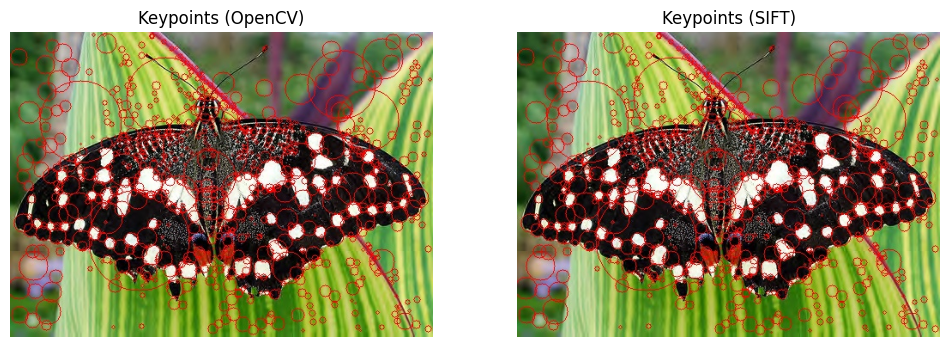

In [33]:
import cv2 as cv
import matplotlib.pyplot as plt

# Read the images
image1 = cv.imread('keypoints_opencv.jpg')
image2 = cv.imread('sift_keypoints.jpg')

# Convert BGR to RGB
image1_rgb = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image2_rgb = cv.cvtColor(image2, cv.COLOR_BGR2RGB)

# Plot the images side by side
plt.figure(figsize=(12, 6))

# Display the first image
plt.subplot(1, 2, 1)
plt.imshow(image1_rgb)
plt.title('Keypoints (OpenCV)')
plt.axis('off')

# Display the second image
plt.subplot(1, 2, 2)
plt.imshow(image2_rgb)
plt.title('Keypoints (SIFT)')
plt.axis('off')

plt.show()
